In [1]:
### check out glider data - near 2023's SD-1042 & NDBC buoy 42022
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
import seawater as sw
import csv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from compute_distance import distance

In [2]:
### glider info
path_glider = '/Users/chi/Documents/Data/Glider/'
fn_glider = 'mote-dora-20231023T0000.nc'

### load glider data
ds = nc.Dataset(path_glider + fn_glider)
varnms = list( ds.variables.keys() )
print(varnms)
### load times
vars_time_load = ['time','precise_time']
for var_key in vars_time_load:
    time_here = ds.variables[var_key][:]
    isok = np.isnan(time_here)
    dtime_here = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=time_here[i]) \
                           for i in range(len(time_here))])
    str_exec = var_key.replace('time','dtime')+'= dtime_here'
    exec(str_exec)
del time_here, dtime_here
### load other variables
vars_load = ['latitude','longitude','depth','density','lat_uv','lon_uv','precise_lat','precise_lon','pressure',\
             'salinity','temperature']
for var_key in vars_load:
    print(var_key)
    str_exec = var_key+'= ds.variables[var_key][:]'
    exec(str_exec)

['trajectory', 'wmo_id', 'profile_id', 'time', 'latitude', 'longitude', 'depth', 'conductivity', 'crs', 'density', 'instrument_ctd', 'lat_uv', 'lon_uv', 'platform_meta', 'precise_lat', 'precise_lon', 'precise_time', 'pressure', 'qartod_conductivity_flat_line_flag', 'qartod_conductivity_gross_range_flag', 'qartod_conductivity_primary_flag', 'qartod_conductivity_rate_of_change_flag', 'qartod_conductivity_spike_flag', 'qartod_density_flat_line_flag', 'qartod_density_gross_range_flag', 'qartod_density_primary_flag', 'qartod_density_rate_of_change_flag', 'qartod_density_spike_flag', 'qartod_monotonic_pressure_flag', 'qartod_pressure_flat_line_flag', 'qartod_pressure_gross_range_flag', 'qartod_pressure_primary_flag', 'qartod_pressure_rate_of_change_flag', 'qartod_pressure_spike_flag', 'qartod_salinity_flat_line_flag', 'qartod_salinity_gross_range_flag', 'qartod_salinity_primary_flag', 'qartod_salinity_rate_of_change_flag', 'qartod_salinity_spike_flag', 'qartod_temperature_flat_line_flag', 'q

seconds since 2023-01-01


Text(0.5, 1.0, 'Distance btw buoy-42022 & 2023 SD-1042')

<Figure size 432x288 with 0 Axes>

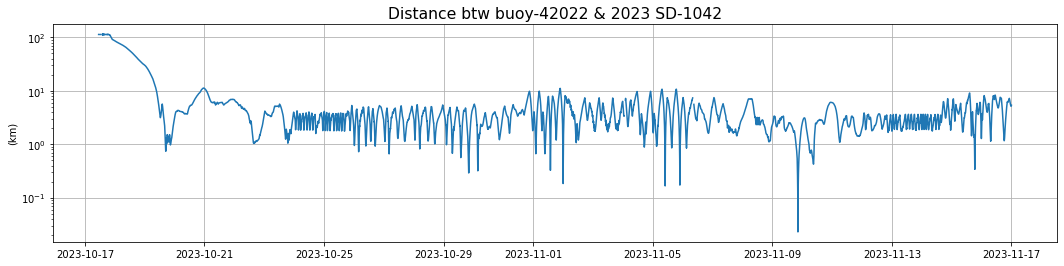

In [ ]:
### buoy data info
year = '2023'
buoy_id = '42022'
lon_buoy = -83.741
lat_buoy = 27.505

### Saildrone data info
year = '2023'
platf_num = '1042'
path_airsea = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'

### load airsea data
ds_airsea = nc.Dataset(path_airsea+'airsea-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_airsea.variables['time'][:]
print(ds_airsea.variables['time'].units)
dtime_airsea = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
lon_SD = ds_airsea.variables['longitude'][:]
lat_SD = ds_airsea.variables['latitude'][:]

### compute distance btw buoy & SD
dist_buoy_SD = np.ones( dtime_airsea.shape )
for t in range( len(dtime_airsea) ):
    dist_buoy_SD[t] = distance(lat_buoy, lon_buoy, lat_SD[t], lon_SD[t])

### plot distance
nrow = 1
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 4)
plt.rcParams.update({'font.size': 13})
###
plt.semilogy( dtime_airsea, dist_buoy_SD )
plt.grid()
plt.ylabel('(km)')
plt.title('Distance btw buoy-'+buoy_id+' & '+year+' SD-'+platf_num)

<Figure size 432x288 with 0 Axes>

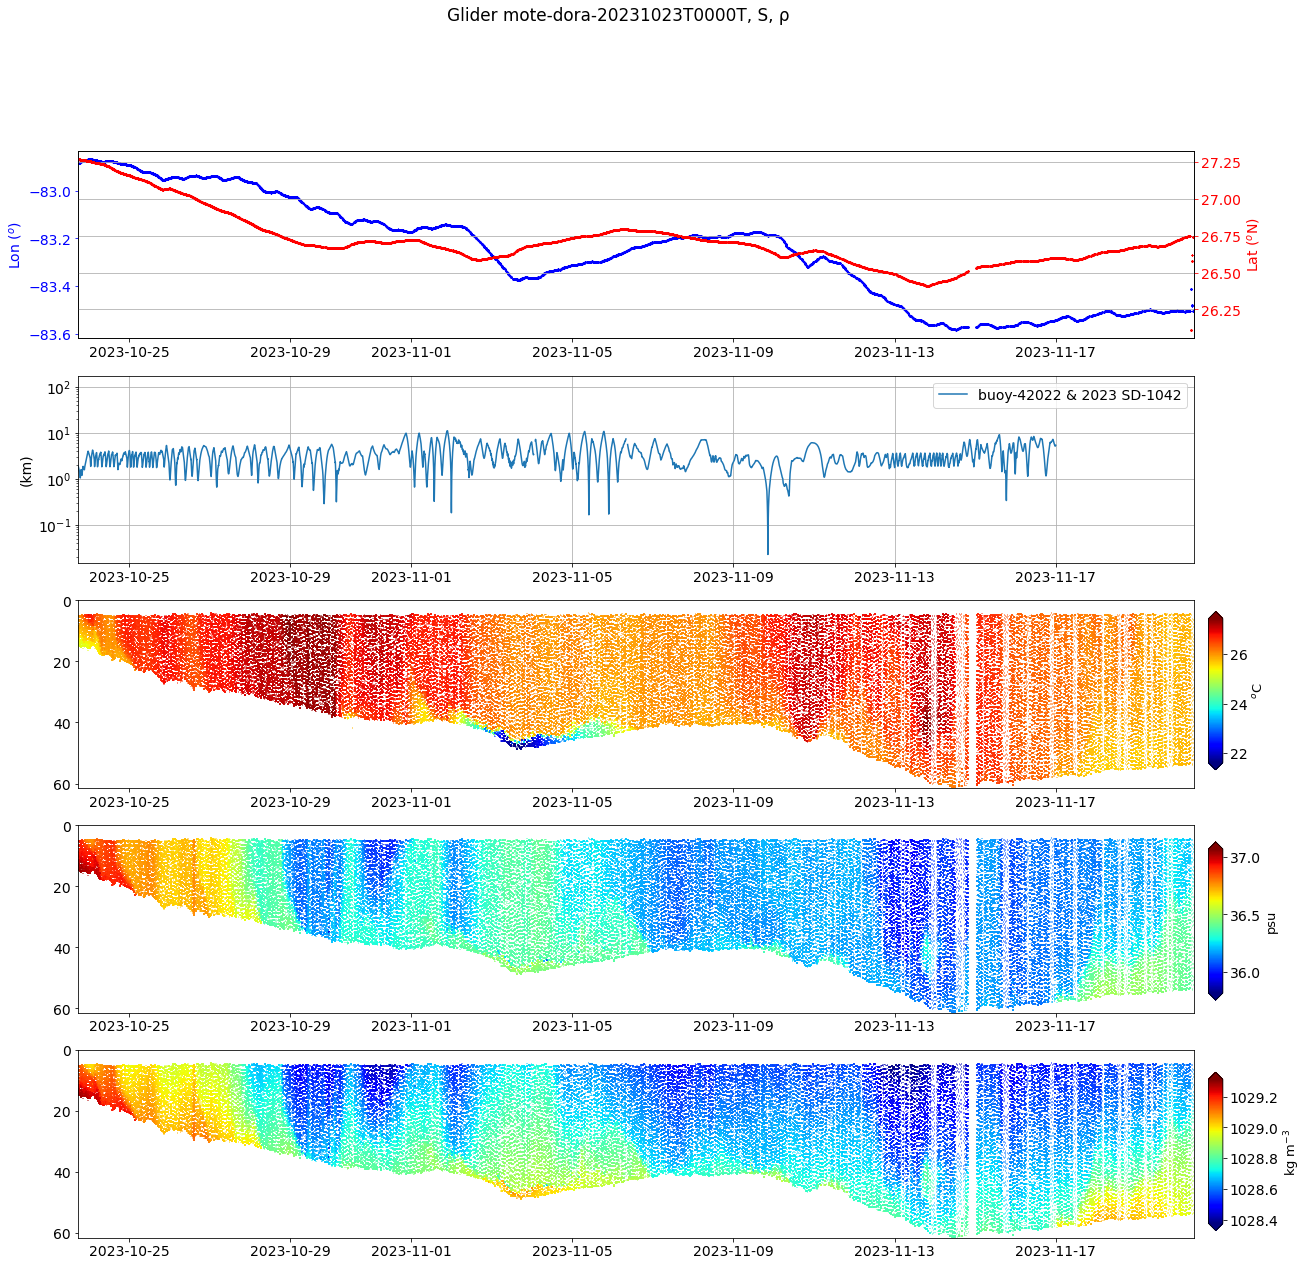

In [6]:
### plot time series
# (1) lon, lat (2) Distance between Glider & SD-1042 (3) time-depth of T (4) time-depth of S (5) time-depth of density
nrow = 5
tlim_plot = [dtime[0],dtime[-1]]
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(20,20)
### (1) lon/ lat
plt.subplot(nrow,1,1)
ax0 = axes[0]
ax1 = ax0.twinx()
col_pos = ['b','r']
ax0.plot(dtime, longitude,'.',ms=1,color=col_pos[0])
ax0.set_ylabel('Lon ($^o$)')
ax1.plot(dtime, latitude,'.',ms=1,color=col_pos[1])
ax1.set_ylabel('Lat ($^o$N)')
plt.xlim(tlim_plot)
plt.grid()
### color settings
for i in range( len(col_pos) ):
    ax_str = 'ax'+str(i); col_i = 'col_pos[i]'
    exec(ax_str+'.yaxis.label.set_color('+col_i+')')
    exec(ax_str+'.tick_params(axis="y",colors='+col_i+')')
### (2) Distance between buoy & SD-1042
plt.subplot(nrow,1,2)
plt.semilogy( dtime_airsea, dist_buoy_SD,label='buoy-'+buoy_id+' & '+year+' SD-'+platf_num )
plt.grid()
plt.xlim(tlim_plot)
plt.ylabel('(km)')
plt.legend()
### (3)(4)(5) time-depth of T, S, density
vars_plot = ['temperature','salinity','density']
vars_unit = ['$^o$C','psu','kg m$^{-3}$']
y0_cbar = [0.45,0.29,0.13]
for i in range( len(vars_plot) ):
    plt.subplot(nrow,1,i+3)
    exec('var_here = '+vars_plot[i])
    clim = [np.nanmin(var_here), np.nanmax(var_here)]
    sc = plt.scatter(dtime, depth, c=var_here, s=0.5, cmap='jet',vmin=clim[0],vmax=clim[1], marker='s')
    plt.xlim(tlim_plot)
    plt.ylim([0,np.nanmax(depth)])
    plt.gca().invert_yaxis()
    ### add colorbar
    cbar_ax = fig.add_axes([0.91,y0_cbar[i],0.01,0.11])
    axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
    axf.set_label(vars_unit[i],fontsize=13)

### save figure
plt.suptitle('Glider '+fn_glider[:-3]+'T, S, \u03C1')
plt.savefig('glider-'+fn_glider+'_pos_TSD_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')\
            +'.png',dpi=300,bbox_inches='tight')